# bob-is-rich

This experiment was presented at [QNLP 2019](file:///Users/alexis.toumi/WORK/discopy/docs/_build/html/talks/qnlp19.html).

In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice = Word('Alice', n)
loves = Word('loves', n.r @ s @ n.l)
Bob =  Word('Bob', n)
who = Word('who', n.r @ n @ s.l @ n)
is_rich = Word('is rich', n.r @ s)

vocab = [Alice, loves, Bob, who, is_rich]

In [2]:
from time import time
from discopy.grammar import brute_force

gen, n_sentences = brute_force(*vocab), 20
sentences, parsing = list(), dict()

print("Brute force search for grammatical sentences:")

start = time()
for i in range(n_sentences):
    diagram = next(gen)
    sentence = ' '.join(str(w)
        for w in diagram.boxes if isinstance(w, Word)) + '.'
    sentences.append(sentence)
    parsing.update({sentence: diagram})
    print(sentence)

print("\n{:.2f} seconds to generate {} sentences.".format(time() - start, n_sentences))

Brute force search for grammatical sentences:
Alice is rich.
Bob is rich.
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.
Alice who is rich is rich.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who loves Bob is rich.
Alice who is rich loves Alice.
Alice who is rich loves Bob.
Bob who loves Alice is rich.
Bob who loves Bob is rich.
Bob who is rich loves Alice.
Bob who is rich loves Bob.
Alice who loves Alice loves Alice.
Alice who loves Alice loves Bob.
Alice who loves Bob loves Alice.
Alice who loves Bob loves Bob.

26.80 seconds to generate 20 sentences.


Diagram for 'Alice who loves Bob is rich.':


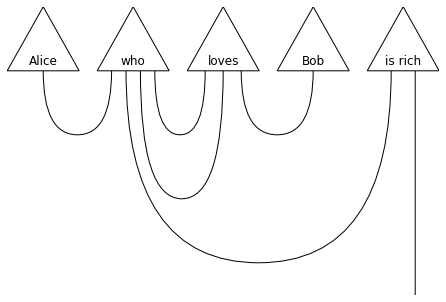

In [3]:
from discopy.grammar import draw
print("Diagram for 'Alice who loves Bob is rich.':")
draw(parsing['Alice who loves Bob is rich.'], draw_type_labels=False)

Circuit for the GHZ state:


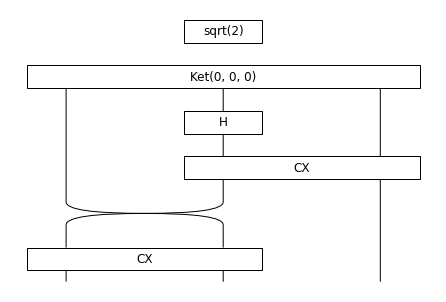

Tensor(dom=Dim(1), cod=Dim(2, 2, 2), array=[1., 0., 0., 0., 0., 0., 0., 1.])


In [4]:
from discopy.quantum import Circuit, sqrt, Ket, H, Rx, CX, SWAP

GHZ = sqrt(2) @ Ket(0, 0, 0)\
    >> Circuit.id(1) @ H @ Circuit.id(1)\
    >> Circuit.id(1) @ CX\
    >> (SWAP >>  CX) @ Circuit.id(1)

print("Circuit for the GHZ state:")
GHZ.draw(aspect='auto', draw_type_labels=False)
print(GHZ.eval())

Circuit for 'Alice who loves Bob is rich.':


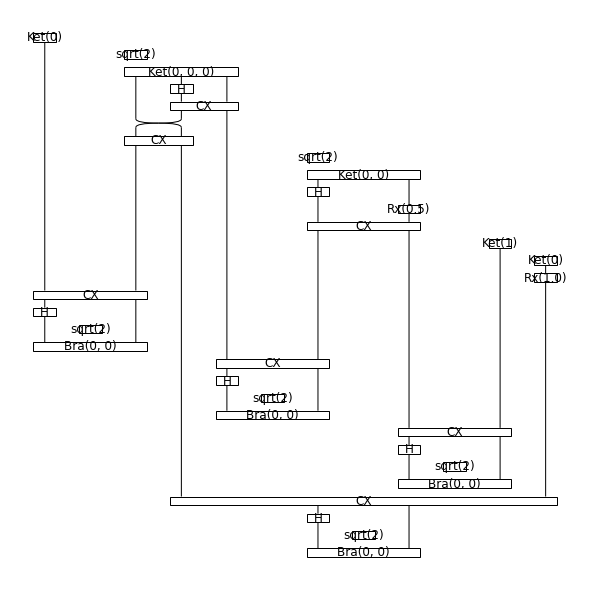

In [5]:
import numpy as np
from discopy import CircuitFunctor, qubit

def intransitive_ansatz(phase):
    return Ket(0) >> Rx(phase)

def transitive_ansatz(phase):
    return sqrt(2) @ Ket(0, 0) >> H @ Rx(phase) >> CX

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0),
    loves: transitive_ansatz(params['loves']),
    Bob: Ket(1),
    who: GHZ,
    is_rich: intransitive_ansatz(params['is_rich'])}

F = lambda params: CircuitFunctor(ob, ar({'loves': params[0], 'is_rich': params[1]}))

params0 = np.array([0.5, 1.])
print("Circuit for 'Alice who loves Bob is rich.':")
F(params0)(parsing['Alice who loves Bob is rich.']).draw(
    figsize=(8, 8), aspect='auto', draw_type_labels=False)

In [6]:
evaluate = lambda F, sentence: F(parsing[sentence]).measure()
corpus = {sentence: evaluate(F(params0), sentence) for sentence in sentences}

epsilon = 1e-2

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability < epsilon)))

True sentences:
Alice is rich.
Alice loves Bob.
Bob loves Alice.
Alice who is rich is rich.
Alice who loves Bob is rich.
Alice who is rich loves Bob.
Alice who loves Bob loves Bob.

False sentences:
Bob is rich.
Alice loves Alice.
Bob loves Bob.
Bob who is rich is rich.
Alice who loves Alice is rich.
Alice who is rich loves Alice.
Bob who loves Alice is rich.
Bob who loves Bob is rich.
Bob who is rich loves Alice.
Bob who is rich loves Bob.
Alice who loves Alice loves Alice.
Alice who loves Alice loves Bob.
Alice who loves Bob loves Alice.


In [7]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.5, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(str, sentence_test))))

Training set:
Bob who loves Bob is rich.
Alice loves Alice.
Alice who loves Bob is rich.
Alice who loves Bob loves Bob.
Bob loves Alice.
Bob who loves Alice is rich.
Bob who is rich is rich.
Alice who is rich loves Alice.
Bob who is rich loves Alice.
Alice who is rich is rich.

Testing set:
Alice is rich.
Alice who loves Alice loves Bob.
Bob who is rich loves Bob.
Bob is rich.
Alice who loves Alice is rich.
Bob loves Bob.
Alice who is rich loves Bob.
Alice loves Bob.
Alice who loves Bob loves Alice.
Alice who loves Alice loves Alice.


In [8]:
from jax import jit
import jax.numpy as np

from discopy import Tensor

Tensor.np = np  # This ensures we can differentiate Circuit.eval with respect to phases.

@jit
def training_loss(params):
    return np.mean(np.array([
        (corpus[sentence] - evaluate(F(params), sentence)) ** 2
        for sentence in sentence_train]))

@jit
def testing_loss(params):
    return np.mean(np.array([
        (corpus[sentence] - evaluate(F(params), sentence)) ** 2
        for sentence in sentence_test]))

start = time()
print("Training loss: {}".format(training_loss(params0)))
print("Testing loss: {}".format(testing_loss(params0)))
print("\n{:.0f} seconds to compile the loss.".format(time() - start))

/Users/alexis.toumi/.pyenv/versions/3.8.5/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Training loss: 2.273736618907049e-14
Testing loss: 1.2789768057835677e-14

5 seconds to compile the loss.


In [9]:
from jax import grad

step_size = 1e-2

@jit
def update(params):
    return params - step_size * grad(training_loss)(params)

start = time()
p_loves, p_is_rich = update(params0)
print("params['loves'] = {}".format(p_loves))
print("params['is rich'] = {}".format(p_is_rich))
print("\n{:.0f} seconds to compile the update.".format(time() - start))

params['loves'] = 0.5
params['is rich'] = 1.0

7 seconds to compile the update.


In [10]:
from random import random, seed; seed(420)

params = np.array([random(), random()])

print("Random initialisation: {}".format(params))
print("Initial training loss: {}".format(training_loss(params)))
print("Initial testing loss: {}".format(testing_loss(params)))

print("\nIs Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(F(params), 'Alice who loves Bob is rich.') > 1 - epsilon
      else "No, she isn't.")

Random initialisation: [0.02634338 0.78136903]
Initial training loss: 0.49155735969543457
Initial testing loss: 0.477308988571167

Is Alice who loves Bob rich?
No, she isn't.


In [11]:
epochs, iterations = 3, 333

for i in range(epochs):
    start_epoch = time()

    for j in range(iterations):
        start_iteration = time()
        params = update(params)

        if i == 0 and j < 3:
            print("Update {} ({:.0f} microseconds)".format(j, 1e6 * (time() - start_iteration)))
            print("params['loves'] = {:.3f}".format(params[0]))
            print("params['is rich'] = {:.3f}".format(params[1]))
            print("Training loss: {}".format(training_loss(params)))
            print("Testing loss: {}\n".format(testing_loss(params)))

    print("Epoch {} ({:.0f} milliseconds)".format(i, 1e3 * (time() - start_epoch)))
    print("params['loves'] = {:.3f}".format(params[0]))
    print("params['is rich'] = {:.3f}".format(params[1]))
    print("Training loss: {}".format(training_loss(params)))
    print("Testing loss: {}\n".format(testing_loss(params)))

Update 0 (2313 microseconds)
params['loves'] = 0.030
params['is rich'] = 0.786
Training loss: 0.4885895848274231
Testing loss: 0.4739306569099426

Update 1 (658 microseconds)
params['loves'] = 0.033
params['is rich'] = 0.790
Training loss: 0.4855433404445648
Testing loss: 0.47031304240226746

Update 2 (1152 microseconds)
params['loves'] = 0.037
params['is rich'] = 0.794
Training loss: 0.4823097288608551
Testing loss: 0.46630293130874634

Epoch 0 (300 milliseconds)
params['loves'] = 0.478
params['is rich'] = 0.977
Training loss: 4.149269807385281e-05
Testing loss: 2.620711165945977e-05

Epoch 1 (78 milliseconds)
params['loves'] = 0.485
params['is rich'] = 0.984
Training loss: 9.46286763792159e-06
Testing loss: 5.948916623310652e-06

Epoch 2 (78 milliseconds)
params['loves'] = 0.488
params['is rich'] = 0.987
Training loss: 4.0742756937106606e-06
Testing loss: 2.5570273010089295e-06



In [12]:
print("Is Alice who loves Bob rich?")
print("Yes, she is."
      if evaluate(F(params), 'Alice who loves Bob is rich.') > 1 - epsilon
      else "No, she isn't.")

Is Alice who loves Bob rich?
Yes, she is.


In [13]:
from jax import vmap

start = time()

x, y = np.meshgrid(np.arange(-1.0, 1.0, 1e-2), np.arange(-1.0, 1.0, 1e-2))
xy = np.dstack((x.flatten(), y.flatten()))[0]
z = vmap(training_loss)(xy).reshape(x.shape)

print("{:.3f} seconds to compute the landscape.".format(time() - start))

4.180 seconds to compute the landscape.


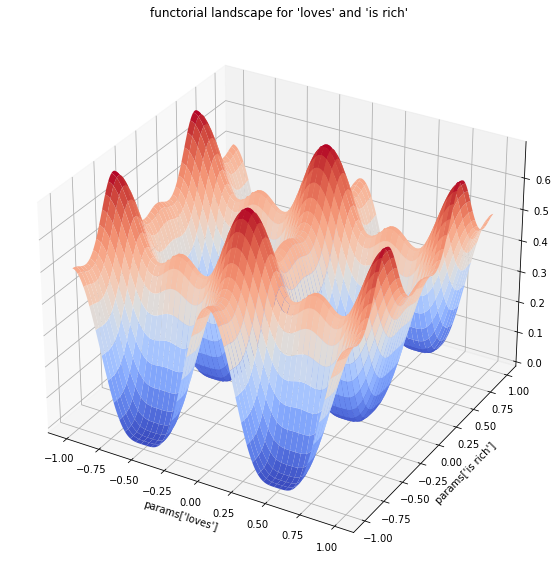

In [14]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm)
plt.xlabel("params['loves']")
plt.ylabel("params['is rich']")
plt.title("functorial landscape for 'loves' and 'is rich'")
plt.show()